---
# <center> Recurrent Neural Network (RNN)
---
<font color="LIGHTSLATEGRAY">Prepared by **NICHOLAS DOMINIC**
<br>Guided from *Aurélien Géron*'s **Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow** (2nd ed., by O’Reilly Media, Inc.)
<br>Powered by Interactive Python **Jupyter Notebook** (.ipynb), developed with **Python 3.7**

In [1]:
import numpy as np
import tensorflow as tf
from pandas import DataFrame as df
from tensorflow import keras
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator as mx

In [2]:
np.__version__, tf.__version__, keras.__version__

('1.18.2', '2.2.0', '2.3.0-tf')

## RNN Supporting User-defined Function

In [3]:
def generate_time_series_data(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # .randn(d0, d1, ..., dn) means dimension, in this case will be 4 x batch_size x 1 array
    time = np.linspace(0, 1, n_steps) # return evenly spaced numbers over a specified interval, .linspace(start, stop, number_of_samples)
    
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    
    return series[..., np.newaxis].astype(np.float32) # ... means Ellipsis, the element that points to the list itself, see on stackoverflow.com/questions/17160162/what-do-ellipsis-mean-in-a-list

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    plt.grid(True)
    plt.hlines(0, 0, 100, linewidth=1, linestyles='dashed') # (0, 0, 100) == (y-axis, x-axis_min, x-axis_max)
    plt.axis([0, n_steps + 1, -1, 1]) # x_axis-min, x_axis-max, y-axis_min, y-axis_max
    
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    if x_label: # not FALSE
        plt.xlabel(x_label, fontsize=16)
    if y_label: # not FALSE
        plt.ylabel(y_label, fontsize=16)

In [6]:
def plot_forecast(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    
    plt.axis([0, n_steps + ahead, -1, 1]) # x_axis-min, x_axis-max, y-axis_min, y-axis_max
    plt.legend(loc='best') # legend with adaptive location
    plt.grid(True)

In [44]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

## Time Series Dataset Loading

In [8]:
n_steps = 50
series = generate_time_series_data(10000, n_steps + 1) # batch_size, n_steps
print("All SERIES {}".format(series.shape))

# since we have series.shape = (10000, 51, 1) then it'll be split as
x_train, y_train = series[:7000, :n_steps], series[:7000, -1]
x_val, y_val = series[7000:9000, :n_steps], series[7000:9000, -1]
x_test, y_test = series[9000:, :n_steps], series[9000:, -1]

print("x_train {} y_train {}".format(x_train.shape, y_train.shape))
print("x_val {} y_val {}".format(x_val.shape, y_val.shape))
print("x_test {} y_test {}".format(x_test.shape, y_test.shape))

All SERIES (10000, 51, 1)
x_train (7000, 50, 1) y_train (7000, 1)
x_val (2000, 50, 1) y_val (2000, 1)
x_test (1000, 50, 1) y_test (1000, 1)


## Recurrent Neural Network (RNN)

In [9]:
simple_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
simple_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [10]:
simple_rnn_model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=5e-3), metrics=['mse'])
simple_rnn_history = simple_rnn_model.fit(x_train, y_train, epochs=15, batch_size=1, validation_data=(x_val, y_val))

Epoch 1/15
7000/7000 [==============================] - 64s 9ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 2/15
7000/7000 [==============================] - 110s 16ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 3/15
7000/7000 [==============================] - 106s 15ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 4/15
7000/7000 [==============================] - 109s 16ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 5/15
7000/7000 [==============================] - 97s 14ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 6/15
7000/7000 [==============================] - 113s 16ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 7/15
7000/7000 [==============================] - 99s 14ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 8/15
7000/7000 [=======================

Text(0, 0.5, 'Scores')

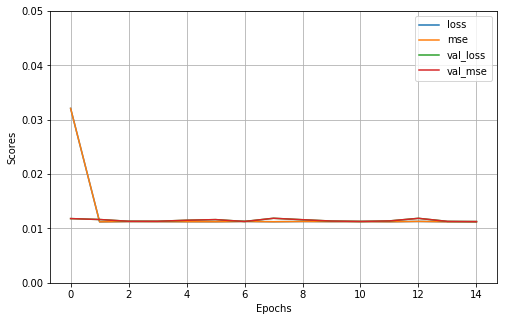

In [11]:
df(simple_rnn_history.history).plot(figsize=(8, 5))
plt.ylim(0, .05)
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Scores")

In [12]:
simple_rnn_model.evaluate(x_val, y_val, batch_size=1)

2000/2000 [==============================] - 13s 6ms/step - loss: 0.0112 - mse: 0.0112


[0.011233573779463768, 0.011233573779463768]

All new SERIES (1, 60, 1)
x_new (1, 50, 1) y_new (1, 10, 1) y_pred (1, 10, 1)


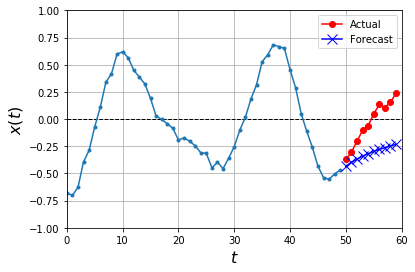

In [35]:
new_series = generate_time_series_data(1, n_steps + 10)
x_new, y_new = new_series[:, :n_steps], new_series[:, n_steps:]

x_copied = x_new # copy x_new to another variable so its original shape doesn't change due to concatenation
for step_ahead in range(10):
    y_pred_one = simple_rnn_model.predict(x_copied[:, step_ahead:])[:, np.newaxis, :]
    x_copied = np.concatenate([x_copied, y_pred_one], axis=1)

y_pred = x_copied[:, n_steps:]
print("All new SERIES {}".format(new_series.shape))
print("x_new {} y_new {} y_pred {}".format(x_new.shape, y_new.shape, y_pred.shape))

plot_forecast(x_new, y_new, y_pred)